In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('analytics_test.csv')
#pd.set_option('display.max_rows', 300)

# Предварительный анализ

Будем исходить из следующего простого критерия: 

    Результат выдачи тем хуже, чем больше пользователю пришлось промотать вниз (чем больше номер в колонке "click_position"). 
    
Исходит этот критерий из очевидного желания. Пользователь, вбивший запрос, хочет тратить как можно меньше времени на поиски. Поэтому в идеале хороший запрос, это когда то, что искал пользователь (или не искал, но это зацепило его внимание) находится в первом пункте выдачи.    

Давайте рассмотрим распределение количества **кликов**, которые были на n-ой позиции выдаче поиска по категориям фильмы, шоу, новости и музыка. 

Text(0.5, 1.0, 'распределение для music')

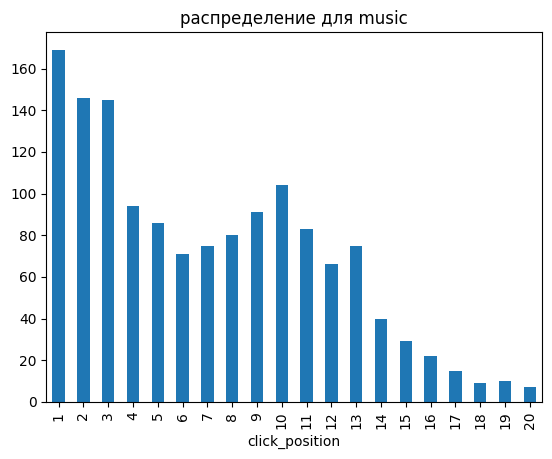

In [2]:
df.loc[(df['event'] == "tap") & (df['query_type'] == 'music')]['click_position'].value_counts().sort_index().plot(kind='bar')

plt.title('распределение для music')

Text(0.5, 1.0, 'распределение для show')

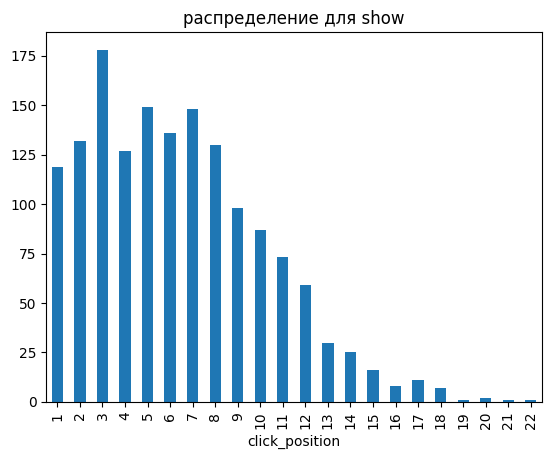

In [3]:
df.loc[(df['event'] == "tap") & (df['query_type'] == 'show')]['click_position'].value_counts().sort_index().plot(kind='bar')

plt.title('распределение для show')

Text(0.5, 1.0, 'распределение для news')

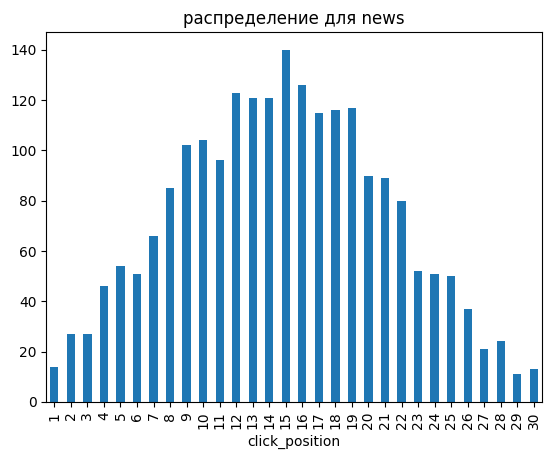

In [4]:
df.loc[(df['event'] == "tap") & (df['query_type'] == 'news')]['click_position'].value_counts().sort_index().plot(kind='bar')

plt.title('распределение для news')

Text(0.5, 1.0, 'распределение для films')

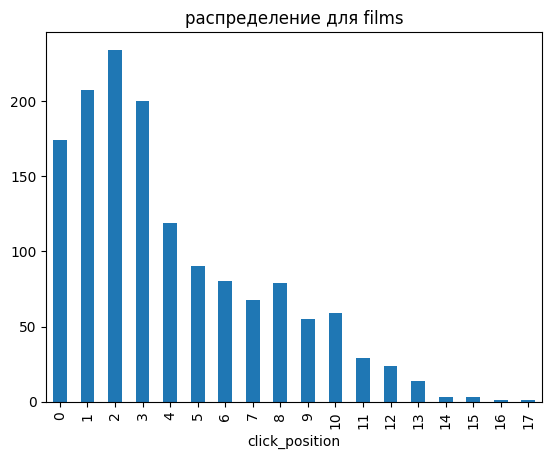

In [5]:
df.loc[(df['event'] == "tap") & (df['query_type'] == 'films')]['click_position'].value_counts().sort_index().plot(kind='bar')

plt.title('распределение для films')

Уже здесь явно видно, что 

1. Фильмы поиск выдает хорошо
2. Шоу чуть хуже, но тоже неплохо
3. Музыку еще хуже
4. И новости уже распределены по нормальному распределению, что очень плохо

То есть в плане музыки и в особенности новостей поиск работает не так хорошо как хотелось бы. 

Вопрос в том почему так происходит.

Первый ответ который приходит в голову, что плохо работают алгоритмы. Тут надо проверять, что будет если поменять алгоритм и в идеале провести какое нибудь тестированние. В общем, данных недостаточно.

Второй ответ который мог бы быть это то, что недостаточно контента, например, связанного с новостями. Но пользователи все таки находят какой то контент на который они кликнули, пусть даже далеко не на первом пункте выдачи. Тут возникает другой вопрос, а действтельно ли этот контент нравится пользователям, ведь то что они кликнули лишь значит что он их заинтересовал. На вопрос смог ли контент захватить их внимание или понравился ли, клик пользователя не отвечает. Тут надо отдельно посмотреть вовлеченность пользователей, что мы сделаем ниже.

Третий ответ может быть связан с внутренними механизмами пользователя. Например, он считает что первые результаты выдачи необъективны или неполны (если говорить про новости). Или ища музыку человек хочет найти, что то более андерграундное и аутентичное. Тут нужно уже работать непосредственно с пользователями и смотреть на их поведение (На что у нас не хватает данных. На подавляющее большиство user_id в датасете приходится 1-2 запроса, а в общем не больше 4 запросов на пользователя. Этого мало для исследования его поведения) или провести соц исследование. 

# Что с новостями ?

Клики это хорошо, но что по вовлеченности? Для начала посмотрим ка пользовтели оценивают пункты выдачи. 

In [6]:
# соотношение лайков к просмотрам

vw = len(df.loc[(df['query_type'] == 'news') & (df['event'] == 'view')])
lk = len(df.loc[(df['query_type'] == 'news') & (df['event'] == 'like')])

lk/vw

0.7356687898089171

соотношение 74% очень хорошо, но насколько релеванты эти данные ?

In [7]:
# строки с просмотрами и лайками соотвественно
usersv = df.loc[(df['query_type'] == 'news') & (df['event'] == 'view')]['user_id']
usersl = df.loc[(df['query_type'] == 'news') & (df['event'] == 'like')]['user_id']

In [8]:
# ищем есть ли среди пользователей поставивших лайк пользователь посмотревший видио
intersection = usersl.isin(usersv)
len(intersection[intersection == True]) / len(usersl)


0.0

Что то здесь не так. Получается, что пользователи ставят лайки без просмотров. Это говорит о неполноте датафрейма, либо, что происходит накрутка. Также, возможно, пользователи действительно ставят лайки не смотря видео, но это маловероятно.

В общем на эти данные полагаться не стоит, а по хорошему нужно узнать была ли накрутка или же это неполнота данных. 

Со стороны оценки пользователей подойти не получилось, давайте подойдем с другой. Будем оценивать вовлеченность через время просмотра. Для начала нужно понять, что пользователи смотрят либо клипы, либо видео и оценивать время просмотра нужно по разному, ведь клипы ролики короткого формата. Второе, так как у нас нет данных о полном времени того или иного видео, то будем смотреть не на относительное время а на абсолютное. В среднем человеческое внимание можно удерживать на проятжении 10 -- 15 минут, поэтому будем считать видио интересным если его смотрели больше 10 минут. С клипами ситуация сложнее ведь разброс от 5 до 300 секунд, поэтому анализ клипов лучше проводить по относительному времени. 



In [9]:
times = df.loc[(df['query_type'] == 'news') & (df['event'] == 'view') & (df['doc_type'] == 'video') & (df['view_time'] > 0)]

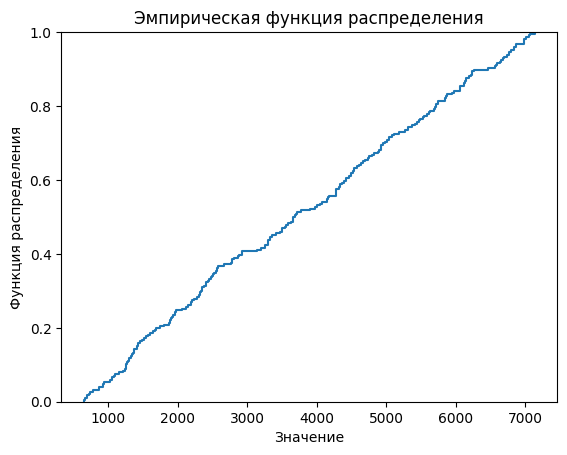

In [10]:
import seaborn as sns

# Создаем график
sns.ecdfplot(data = times, x='view_time')
plt.xlabel('Значение')
plt.ylabel('Функция распределения')
plt.title('Эмпирическая функция распределения')
plt.show()


Тут уже видно, что вероятность попадания в интервал от 3600 примерно половина. Давайте посчитаем более точно.

In [11]:
len(times.loc[times['view_time'] > 3600 ])/len(times)

0.5176991150442478

Как и предполагалось, примерно половина. Тогда можно предположить что действительно дело в недостатаке контента. Однако, делать поспешных выводов не стоит. Все таки новости часто могут быть в коротких форматах и тогда оценка от 10 минут не имеет смысла. Здесь нужны более полные данные, а именно процент просмотренного времени от общей длины ролика.

# Выводы

Подытоживая, есть очевидная проблема с выдачей новстного контента, в среднем люди выбирают контент на 15 позиции поиска. Почему это происходит точно сказать нельзя. Однако есть предположение в недостаточном количестве и качестве контента. Также есть другие предположения, но на их проверку не хватает данных.

## Рекомендации

Собрать больше данных, а именно:
1. Больше данных о каждом отдельном пользователе чтобы можно было изучать их поведение и более точно оценивать результаты.
2. Добавить данные о процентном просмотре времени ролика от общей длины ролика. Чтобы можно было более точно изучить вовлеченность пользователей в контент.
3. Собрать данные о накрутках, посмотреть на ролики и соотношение просмотров/процентного времени просмотра и лайков. Накрутки очень плохо влияют на качество выдачи контента и с этим нужно бороться. 